In [1]:
import os
import cv2
import copy
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Load Data

In [2]:
dataset_path = '7.1. FFT_Plot'

image_paths = []
labels = []

for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):
        for filename in os.listdir(label_path):
            file_path = os.path.join(label_path, filename)
            image_paths.append(file_path)
            labels.append(int(label))

data = pd.DataFrame({'image_path': image_paths, 'label': labels})

dataset = []
labels = []
size = 145

for _, row in data.iterrows():
    source_path = row['image_path']
    label = row['label']
    image = cv2.imread(source_path)
    if image is not None:
        resized_image = cv2.resize(image, (size, size))
        rescaled_image = resized_image / 255.0
        dataset.append(rescaled_image)
        labels.append(label)

dataset = np.array(dataset)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)

def to_categorical(y, num_classes):
    return np.eye(num_classes)[y]

num_classes = len(np.unique(labels))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print('Shape data train:', X_train.shape)
print('Shape data test :', X_test.shape)
print('Shape label train:', y_train.shape)
print('Shape label test :', y_test.shape)


Shape data train: (1800, 145, 145, 3)
Shape data test : (450, 145, 145, 3)
Shape label train: (1800, 4)
Shape label test : (450, 4)


## CNN-LSTM

In [3]:
# Fungsi inisialisasi bobot dan bias
def init_weights(shape):
    return np.random.randn(*shape) * 0.1

def init_weights_he(shape):
  return np.random.randn(*shape) * np.sqrt(2.0 / shape[0])

# Fungsi aktivasi ReLU
def relu(x):
    return np.maximum(0, x)

# Fungsi turunan ReLU untuk backpropagation
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Fungsi Softmax untuk aktivasi layer output
def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

# Fungsi untuk menghitung loss Categorical Cross-Entropy
def categorical_crossentropy(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / y_true.shape[0]

# Turunan dari fungsi loss Categorical Cross-Entropy
def categorical_crossentropy_derivative(y_true, y_pred):
    return y_pred - y_true

 # Gradient Clipping untuk mengatasi vanishing/exploding gradients
def clip_gradients(gradients, threshold=1.0):
    norm = np.linalg.norm(gradients)
    if norm > threshold:
        gradients = gradients * (threshold / norm)
    return gradients

# Fungsi Dropout
def dropout(X, rate):
    mask = np.random.rand(*X.shape) > rate
    return X * mask / (1 - rate)

# Fungsi untuk Learning Rate Exponential Decay
def exponential_decay(epoch, initial_lr, decay_rate=0.95):
    return initial_lr * (decay_rate ** epoch)

# Fungsi Early Stopping
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_val_accuracy = 0
        self.wait = 0
        self.stopped_epoch = 0
        self.stop_training = False

    def on_epoch_end(self, val_accuracy):
        if val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = val_accuracy
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stop_training = True
                self.stopped_epoch = epochs

# Layer dengan Regularisasi L2
def l2_regularization(weights, lambda_=0.01):
    return lambda_ * np.sum(weights ** 2)
    
# Layer konvolusi sederhana (2D Convolution)
def conv2d(X, W, b):
    n_samples, height, width, channels = X.shape
    num_filters, kernel_height, kernel_width, filter_channels = W.shape
    out_height = height - kernel_height + 1
    out_width = width - kernel_width + 1
    output = np.zeros((n_samples, out_height, out_width, num_filters))

    for i in range(out_height):
        for j in range(out_width):
            region = X[:, i:i + kernel_height, j:j + kernel_width, :]
            output[:, i, j, :] = np.tensordot(region, W, axes=([1, 2, 3], [1, 2, 3])) + b
    return relu(output)

# Backpropagation untuk layer konvolusi
def conv2d_backward(d_output, X, W):
    # Ambil dimensi input X dan filter W
    n_samples, height, width, channels = X.shape
    num_filters, kernel_height, kernel_width, filter_channels = W.shape

    # Ambil dimensi output dari d_output
    if len(d_output.shape) == 4:
        _, out_height, out_width, _ = d_output.shape
    else:
        raise ValueError("d_output harus memiliki 4 dimensi, tetapi ditemukan: " + str(d_output.shape))

    # Inisialisasi gradien
    dW = np.zeros_like(W)
    db = np.zeros((1, num_filters))
    dX = np.zeros_like(X)

    for i in range(out_height):
        for j in range(out_width):
            region = X[:, i:i + kernel_height, j:j + kernel_width, :]
            for f in range(num_filters):
                dW[f] += np.sum(region * d_output[:, i:i + 1, j:j + 1, f:f + 1], axis=0)
                db[:, f] += np.sum(d_output[:, i, j, f])
                dX[:, i:i + kernel_height, j:j + kernel_width, :] += d_output[:, i:i + 1, j:j + 1, f:f + 1] * W[f]

    return dX, dW, db



# Fungsi Max Pooling
def max_pool2d(X, pool_size=2):
    n_samples, height, width, channels = X.shape
    out_height = height // pool_size
    out_width = width // pool_size
    output = np.zeros((n_samples, out_height, out_width, channels))

    for i in range(out_height):
        for j in range(out_width):
            region = X[:, i*pool_size:(i+1)*pool_size, j*pool_size:(j+1)*pool_size, :]
            output[:, i, j, :] = np.max(region, axis=(1, 2))
    return output

class SimpleLSTM:
    def __init__(self, input_dim, units):
        self.units = units
        self.Wx = init_weights((input_dim, units))
        self.Wh = init_weights((units, units))
        self.b = init_weights((1, units))

    def forward(self, X):
        batch_size, time_steps, features = X.shape
        self.h = np.zeros((batch_size, self.units))
        self.outputs = np.zeros((batch_size, time_steps, self.units))
        self.inputs = X  # Menyimpan input untuk backpropagation

        for t in range(time_steps):
            self.h = np.tanh(np.dot(X[:, t, :], self.Wx) + np.dot(self.h, self.Wh) + self.b)
            self.outputs[:, t, :] = self.h

        return self.outputs[:, -1, :]  # return last output only

    def backward(self, d_output, learning_rate):
        batch_size, time_steps, features = self.inputs.shape
        dWx = np.zeros_like(self.Wx)
        dWh = np.zeros_like(self.Wh)
        db = np.zeros_like(self.b)
        dX = np.zeros_like(self.inputs)

        # Inisialisasi gradien untuk hidden state terakhir
        dh_next = d_output

        # Backpropagation Through Time (BPTT)
        for t in reversed(range(time_steps)):
            # Gradien untuk tanh pada output (self.outputs)
            dtanh = (1 - self.outputs[:, t, :] ** 2) * dh_next

            # Gradien parameter
            dWx += np.dot(self.inputs[:, t, :].T, dtanh)
            dWh += np.dot(self.h.T, dtanh)
            db += np.sum(dtanh, axis=0, keepdims=True)

            # Gradien untuk input X
            dX[:, t, :] = np.dot(dtanh, self.Wx.T)

            # Update dh_next untuk langkah waktu berikutnya
            dh_next = np.dot(dtanh, self.Wh.T)

        # Update parameter LSTM
        self.Wx -= learning_rate * dWx
        self.Wh -= learning_rate * dWh
        self.b -= learning_rate * db

        return dh_next  # Gradien terhadap input LSTM untuk diteruskan ke layer sebelumnya


# Dense layer dengan Softmax
class Dense:
    def __init__(self, input_dim, units):
        self.W = init_weights((input_dim, units))
        self.b = np.zeros((1, units))

    def forward(self, X):
        self.X = X
        return np.dot(X, self.W) + self.b

    def backward(self, d_output, learning_rate):
        dW = np.dot(self.X.T, d_output)
        db = np.sum(d_output, axis=0, keepdims=True)
        dX = np.dot(d_output, self.W.T)
        self.W -= learning_rate * dW
        self.b -= learning_rate * db
        return dX

class CNNLSTMModel:
    def __init__(self, num_filters, kernel_size, pool_size, lstm_units, num_classes, dropout_rate):
        self.conv_W = init_weights_he((num_filters, kernel_size, kernel_size, 3))
        self.conv_b = np.zeros((1, num_filters))
        self.lstm = SimpleLSTM(input_dim=num_filters, units=lstm_units)
        self.dense = Dense(input_dim=lstm_units, units=num_classes)
        self.dropout_rate = dropout_rate

    def forward(self, X):
        # Convolutional Layer with Batch Normalization and ReLU
        X = conv2d(X, self.conv_W, self.conv_b)
        X = max_pool2d(X, pool_size)
        X = max_pool2d(X, pool_size)
        X = batch_normalization(X)  # Menambahkan Batch Normalization
        batch_size, height, width, channels = X.shape
        X = X.reshape(batch_size, height * width, channels)

        # LSTM Layer with Dropout and Batch Normalization
        X = self.lstm.forward(X)
        X = batch_normalization(X)  # Batch normalization sebelum dropout
        X = dropout(X, self.dropout_rate)

        # Dense layer with Softmax
        X = self.dense.forward(X)
        return softmax(X)

    def backward(self, X, y_true, y_pred, learning_rate):
        d_output = categorical_crossentropy_derivative(y_true, y_pred)

        # Backward Propagation
        d_dense = self.dense.backward(d_output, learning_rate)
        d_dense = clip_gradients(d_dense, threshold=1.0)

        d_lstm = self.lstm.backward(d_dense, learning_rate)
        d_lstm = clip_gradients(d_lstm, threshold=1.0)

        d_lstm = d_lstm[:, np.newaxis, np.newaxis, :]
        d_conv, dW, db = conv2d_backward(d_lstm, X, self.conv_W)

        # Regularisasi L2 pada layer konvolusi dan dense
        dW += l2_regularization(self.conv_W)
        db += l2_regularization(self.conv_b)

        # Gradient clipping untuk convolution gradients
        dW = clip_gradients(dW, threshold=1.0)
        db = clip_gradients(db, threshold=1.0)

        # Update weights
        self.conv_W -= learning_rate * dW
        self.conv_b -= learning_rate * db

# Fungsi Batch Normalization
def batch_normalization(X, epsilon=1e-5):
    mean = np.mean(X, axis=0)
    variance = np.var(X, axis=0)
    X_norm = (X - mean) / np.sqrt(variance + epsilon)
    return X_norm

def pad_last_batch(X_batch, batch_size):
    if X_batch.shape[0] < batch_size:
        pad_size = batch_size - X_batch.shape[0]
        padding = np.zeros((pad_size, *X_batch.shape[1:]))
        X_batch = np.vstack((X_batch, padding))
    return X_batch


## Implementasi sesuai hasil parameter terbaik

In [4]:
epochs       = 50
batch_size   = 32
initial_learning_rate = 0.001
kernel_size  = 5
num_filters  = 50
pool_size    = 5 
lstm_units   = 300
dropout_rate = 0.5
num_classes  = len(np.unique(labels))  

In [6]:
# Inisialisasi model, dictionary history, dan early stopping
model = CNNLSTMModel(num_filters=num_filters, 
                     kernel_size=kernel_size, 
                     pool_size=pool_size, 
                     lstm_units=lstm_units, 
                     num_classes=num_classes, 
                     dropout_rate=dropout_rate)
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
early_stopping = EarlyStopping(patience=10)
best_val_accuracy = 0.0
best_model = None

# Loop training dengan Early Stopping
for epoch in range(epochs):
  

    batch_losses = []
    batch_accuracies = []
    num_batches = int(np.ceil(X_train.shape[0] / batch_size))
    learning_rate = exponential_decay(epoch, initial_learning_rate)

    with tqdm(total=num_batches, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Feedforward
            y_pred = model.forward(X_batch)

            # Hitung loss dan akurasi batch            
            loss = categorical_crossentropy(y_batch, y_pred)
            acc = np.mean(np.argmax(y_batch, axis=1) == np.argmax(y_pred, axis=1))

            # Backpropagation
            model.backward(X_batch, y_batch, y_pred, learning_rate)

            batch_losses.append(loss)
            batch_accuracies.append(acc)

            pbar.update(1)

    # Rata-rata loss dan akurasi per epoch
    avg_loss = np.mean(batch_losses)
    avg_acc = np.mean(batch_accuracies)

    # Validasi
    y_val_pred = model.forward(X_test)
    val_loss = categorical_crossentropy(y_test, y_val_pred)
    val_acc = np.mean(np.argmax(y_test, axis=1) == np.argmax(y_val_pred, axis=1))

    # Simpan hasil training ke history
    history['loss'].append(avg_loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(avg_acc)
    history['val_accuracy'].append(val_acc)

    # Simpan model terbaik berdasarkan val_accuracy
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model = copy.deepcopy(model)

    # Update early stopping
    early_stopping.on_epoch_end(val_acc)

    print(f' - loss: {avg_loss:.4f} - accuracy: {avg_acc:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}')

# Simpan model terbaik ke file
if best_model:
    with open('Implementasi_Terbaik_FFT.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    print(f"Model dengan val_accuracy terbaik ({best_val_accuracy:.4f}) disimpan.")


Epoch 1/50: 100%|███████████████████████████████████████████████████████████████████| 57/57 [00:42<00:00,  1.35batch/s]


 - loss: 1.5126 - accuracy: 0.5291 - val_loss: 1.0517 - val_accuracy: 0.6244


Epoch 2/50: 100%|███████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.36batch/s]


 - loss: 1.0316 - accuracy: 0.6338 - val_loss: 0.9747 - val_accuracy: 0.6533


Epoch 3/50: 100%|███████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.37batch/s]


 - loss: 1.0932 - accuracy: 0.5910 - val_loss: 0.9579 - val_accuracy: 0.6378


Epoch 4/50: 100%|███████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.37batch/s]


 - loss: 1.0047 - accuracy: 0.6025 - val_loss: 0.7710 - val_accuracy: 0.6778


Epoch 5/50: 100%|███████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.37batch/s]


 - loss: 0.7929 - accuracy: 0.6738 - val_loss: 0.6335 - val_accuracy: 0.7422


Epoch 6/50: 100%|███████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.6464 - accuracy: 0.7418 - val_loss: 0.5526 - val_accuracy: 0.7733


Epoch 7/50: 100%|███████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.5347 - accuracy: 0.7834 - val_loss: 0.4243 - val_accuracy: 0.8511


Epoch 8/50: 100%|███████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.37batch/s]


 - loss: 0.4599 - accuracy: 0.8196 - val_loss: 0.3475 - val_accuracy: 0.8644


Epoch 9/50: 100%|███████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.3526 - accuracy: 0.8596 - val_loss: 0.3010 - val_accuracy: 0.9000


Epoch 10/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.3016 - accuracy: 0.8953 - val_loss: 0.2030 - val_accuracy: 0.9311


Epoch 11/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.2096 - accuracy: 0.9304 - val_loss: 0.1615 - val_accuracy: 0.9578


Epoch 12/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.1746 - accuracy: 0.9397 - val_loss: 0.1351 - val_accuracy: 0.9578


Epoch 13/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:42<00:00,  1.35batch/s]


 - loss: 0.1396 - accuracy: 0.9534 - val_loss: 0.1535 - val_accuracy: 0.9578


Epoch 14/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.1384 - accuracy: 0.9523 - val_loss: 0.1155 - val_accuracy: 0.9622


Epoch 15/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.1277 - accuracy: 0.9594 - val_loss: 0.0834 - val_accuracy: 0.9822


Epoch 16/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:42<00:00,  1.35batch/s]


 - loss: 0.1188 - accuracy: 0.9622 - val_loss: 0.1012 - val_accuracy: 0.9689


Epoch 17/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.37batch/s]


 - loss: 0.1013 - accuracy: 0.9655 - val_loss: 0.0681 - val_accuracy: 0.9844


Epoch 18/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.37batch/s]


 - loss: 0.0889 - accuracy: 0.9726 - val_loss: 0.0637 - val_accuracy: 0.9800


Epoch 19/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.0827 - accuracy: 0.9737 - val_loss: 0.0687 - val_accuracy: 0.9778


Epoch 20/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.37batch/s]


 - loss: 0.0682 - accuracy: 0.9803 - val_loss: 0.0535 - val_accuracy: 0.9933


Epoch 21/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:44<00:00,  1.29batch/s]


 - loss: 0.0737 - accuracy: 0.9770 - val_loss: 0.0619 - val_accuracy: 0.9778


Epoch 22/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.0759 - accuracy: 0.9814 - val_loss: 0.0565 - val_accuracy: 0.9844


Epoch 23/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.0755 - accuracy: 0.9786 - val_loss: 0.0399 - val_accuracy: 0.9933


Epoch 24/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.0593 - accuracy: 0.9819 - val_loss: 0.0242 - val_accuracy: 0.9956


Epoch 25/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.0657 - accuracy: 0.9770 - val_loss: 0.0517 - val_accuracy: 0.9889


Epoch 26/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.37batch/s]


 - loss: 0.0565 - accuracy: 0.9792 - val_loss: 0.0358 - val_accuracy: 0.9867


Epoch 27/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.0465 - accuracy: 0.9896 - val_loss: 0.0388 - val_accuracy: 0.9844


Epoch 28/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.0553 - accuracy: 0.9868 - val_loss: 0.0313 - val_accuracy: 0.9956


Epoch 29/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.0373 - accuracy: 0.9907 - val_loss: 0.0286 - val_accuracy: 0.9933


Epoch 30/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.0460 - accuracy: 0.9874 - val_loss: 0.0367 - val_accuracy: 0.9867


Epoch 31/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.39batch/s]


 - loss: 0.0402 - accuracy: 0.9874 - val_loss: 0.0359 - val_accuracy: 0.9911


Epoch 32/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.0370 - accuracy: 0.9918 - val_loss: 0.0228 - val_accuracy: 0.9933


Epoch 33/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.0394 - accuracy: 0.9896 - val_loss: 0.0324 - val_accuracy: 0.9933


Epoch 34/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.37batch/s]


 - loss: 0.0403 - accuracy: 0.9857 - val_loss: 0.0208 - val_accuracy: 0.9956


Epoch 35/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.0370 - accuracy: 0.9901 - val_loss: 0.0269 - val_accuracy: 0.9911


Epoch 36/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.39batch/s]


 - loss: 0.0337 - accuracy: 0.9912 - val_loss: 0.0415 - val_accuracy: 0.9867


Epoch 37/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.0382 - accuracy: 0.9901 - val_loss: 0.0297 - val_accuracy: 0.9933


Epoch 38/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:42<00:00,  1.36batch/s]


 - loss: 0.0351 - accuracy: 0.9907 - val_loss: 0.0287 - val_accuracy: 0.9933


Epoch 39/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.0417 - accuracy: 0.9885 - val_loss: 0.0350 - val_accuracy: 0.9933


Epoch 40/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.0389 - accuracy: 0.9907 - val_loss: 0.0374 - val_accuracy: 0.9889


Epoch 41/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.36batch/s]


 - loss: 0.0392 - accuracy: 0.9879 - val_loss: 0.0366 - val_accuracy: 0.9867


Epoch 42/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.0422 - accuracy: 0.9874 - val_loss: 0.0507 - val_accuracy: 0.9867


Epoch 43/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.0512 - accuracy: 0.9836 - val_loss: 0.0426 - val_accuracy: 0.9844


Epoch 44/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.37batch/s]


 - loss: 0.0406 - accuracy: 0.9890 - val_loss: 0.0632 - val_accuracy: 0.9867


Epoch 45/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.36batch/s]


 - loss: 0.0373 - accuracy: 0.9896 - val_loss: 0.0395 - val_accuracy: 0.9911


Epoch 46/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:40<00:00,  1.40batch/s]


 - loss: 0.0436 - accuracy: 0.9885 - val_loss: 0.0589 - val_accuracy: 0.9844


Epoch 47/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:42<00:00,  1.33batch/s]


 - loss: 0.0436 - accuracy: 0.9868 - val_loss: 0.0617 - val_accuracy: 0.9844


Epoch 48/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38batch/s]


 - loss: 0.0369 - accuracy: 0.9890 - val_loss: 0.0664 - val_accuracy: 0.9822


Epoch 49/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.37batch/s]


 - loss: 0.0430 - accuracy: 0.9874 - val_loss: 0.0611 - val_accuracy: 0.9800


Epoch 50/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.36batch/s]


 - loss: 0.0352 - accuracy: 0.9912 - val_loss: 0.0715 - val_accuracy: 0.9778
Model dengan val_accuracy terbaik (0.9956) disimpan.


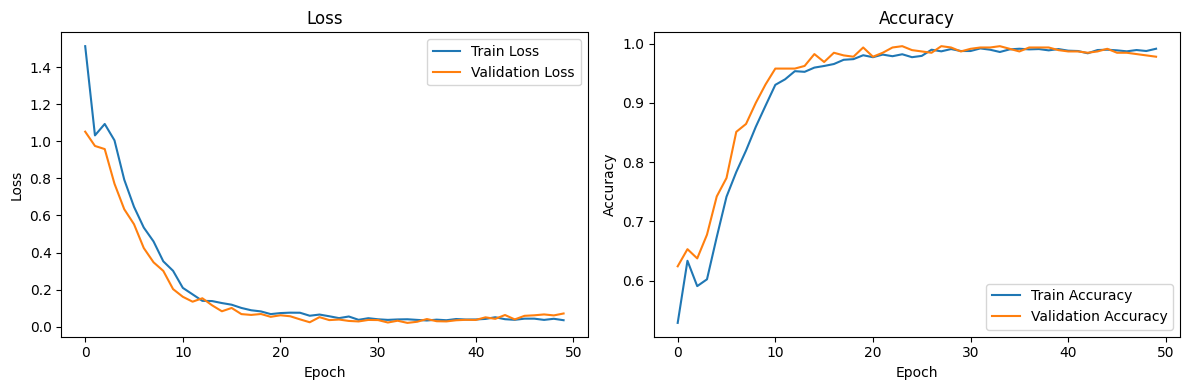

In [7]:
# Plotting loss dan akurasi
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluasi

In [11]:
np.random.seed(123)

# Memuat model terbaik dari file
with open('Implementasi_Terbaik_FFT.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Prediksi pada data testing menggunakan model terbaik
y_pred = best_model.forward(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_test, axis=1)

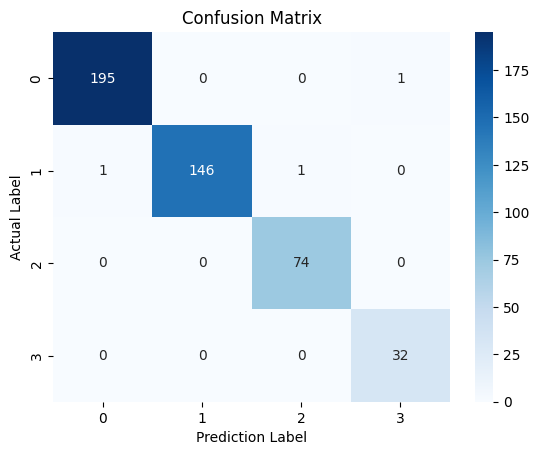

In [12]:
Confusion_matrix = confusion_matrix(y_true, y_pred_classes)
class_label      = np.unique(labels)
df_confusion     = pd.DataFrame(Confusion_matrix, index = class_label, columns = class_label)

sns.heatmap(df_confusion, annot=True, fmt = "d", cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Prediction Label')
plt.ylabel('Actual Label')
plt.show()

In [13]:
# True Positives (TP) berada di diagonal utama
TP = np.diag(Confusion_matrix)

# False Positives (FP) adalah jumlah kolom kecuali diagonal
FP = np.sum(Confusion_matrix, axis=0) - TP

# False Negatives (FN) adalah jumlah baris kecuali diagonal
FN = np.sum(Confusion_matrix, axis=1) - TP

# True Negatives (TN) adalah total semua nilai dikurangi jumlah TP, FP, dan FN
TN = np.sum(Confusion_matrix) - (FP + FN + TP)

# Menampilkan hasil
for i in range(len(TP)):
    print(f"Class {i}:")
    print(f"TP: {TP[i]}, TN: {TN[i]}, FP: {FP[i]}, FN: {FN[i]}\n")

Class 0:
TP: 195, TN: 253, FP: 1, FN: 1

Class 1:
TP: 146, TN: 302, FP: 0, FN: 2

Class 2:
TP: 74, TN: 375, FP: 1, FN: 0

Class 3:
TP: 32, TN: 417, FP: 1, FN: 0



In [14]:
# Total nilai di confusion matrix
total_values = np.sum(Confusion_matrix)

# Akurasi: (Total TP) / (Total elemen di confusion matrix)
accuracy = round((np.sum(TP) / total_values) * 100, 2)

# Menampilkan hasil
print(f"Akurasi: {accuracy} %")

Akurasi: 99.33 %


In [15]:
# Variabel untuk menyimpan jumlah precision, recall, dan f1-score
total_precision = 0
total_recall = 0
total_f1_score = 0

# Menghitung precision, recall, dan f1-score untuk setiap kelas
for i in range(len(TP)):
    # Menghitung precision, recall, dan f1-score (hindari pembagian dengan nol)
    precision = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) != 0 else 0
    recall = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) != 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Menambah nilai precision, recall, dan f1-score ke total
    total_precision += precision
    total_recall += recall
    total_f1_score += f1_score

# Menghitung rata-rata biasa untuk precision, recall, dan f1-score
average_precision = round((total_precision / len(TP))*100, 2)
average_recall    = round((total_recall / len(TP))*100, 2)
average_f1_score  = round((total_f1_score / len(TP))*100, 2)

# Menampilkan hasil rata-rata
print(f"Rata-rata Precision: {average_precision} %")
print(f"Rata-rata Recall   : {average_recall} %")
print(f"Rata-rata F1-Score : {average_f1_score} %")


Rata-rata Precision: 98.78 %
Rata-rata Recall   : 99.53 %
Rata-rata F1-Score : 99.15 %


In [16]:
# Menghitung TPR dan FPR per kelas
TPR = TP / (TP + FN)
FPR = FP / (FP + FN)

# Menampilkan TPR dan FPR per kelas
for i in range(len(TP)):
    print(f"Class {i}:")
    print(f"TPR: {TPR[i]:.4f}, FPR: {FPR[i]:.4f}\n")

Class 0:
TPR: 0.9949, FPR: 0.5000

Class 1:
TPR: 0.9865, FPR: 0.0000

Class 2:
TPR: 1.0000, FPR: 1.0000

Class 3:
TPR: 1.0000, FPR: 1.0000



In [17]:
# Menghitung rata-rata TPR dan FPR
average_TPR = round(np.mean(TPR)*100, 2)
average_FPR = round(np.mean(FPR)*100, 2)

# Menampilkan hasil rata-rata TPR dan FPR
print(f"TPR: {average_TPR} %")
print(f"FPR: {average_FPR} %")

TPR: 99.53 %
FPR: 62.5 %
